In [4]:
"""
Debug lenmap2gclm
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import pysht
import cupy as cp
import sys
from time import process_time
from lenspyx.lensing import get_geom as get_lenspyxgeom
from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from delensalot.utility.plot_helper import bandpass_alms

from pysht.helper import dlm2A

magnific = None
runinfos = [
    # ("CPU", "lenspyx", 'ducc'),
    ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]
epsilon = 1e-14
deflection_epsilon = 1e-14
lmaxs = [63]

phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
wCPU, wGPU = None, None
for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax': lmax})
    lenjob_geominfo = ('gl',{'lmax': phi_lmax})
    # geominfo = ('tgl',{'lmax': lmax, 'smax':2})
    # lenjob_geominfo = ('tgl',{'lmax': phi_lmax, 'smax':2})
    lldlm = np.arange(0, phi_lmax+1)
    print("starting to generate sim data...")
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    print('synunl done')
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo, epsilon=epsilon)
    print('synsky done')
    philm = synunl.get_sim_phi(0, space='alm')
    print('phi generated')
    toydlm = hp.almxfl(philm, np.sqrt(np.arange(phi_lmax + 1, dtype=float) * np.arange(1, phi_lmax + 2)))
    toydlm *= 0.
    philm *= 0.
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    print('unl lm generated')
    # Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
    print('Tsky generated')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    print("Tsky2 generated")
    print("done generating sim data...")
    for runinfo in runinfos:
        shttransformer_desc = 'shtns' if runinfo[0] == 'GPU' else 'ducc'
        kwargs = {
            'geominfo': geominfo,
            'nthreads': 10,
            'epsilon': epsilon,
            'verbosity': 1,
            'planned': False,
            'single_prec': False,
            'shttransformer_desc': shttransformer_desc
        }
        
        deflection_kwargs = {
            'geominfo': lenjob_geominfo,
            'nthreads': 10,
            'epsilon': deflection_epsilon,
            'verbosity': 1,
            'single_prec': False,
            'mmax_dlm': phi_lmax, # this is merely to cut out the m-modes.
            'dlm': toydlm,
        }
        print(runinfo)
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]
        defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
        for mode in ['nuFFT']:
            print("\nTesting:: solver = {} backend = {} mode = {} ...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(**kwargs, deflection_kwargs=deflection_kwargs)
            print("\n----lmax: {}, phi_lmax: {}, dlm_lmax = {}, epsilon: {}----".format(lmax, phi_lmax, hp.Alm.getlmax(toydlm.size), deflection_kwargs['epsilon']))
            
            if runinfo[0] == 'CPU':
                magnific = dlm2A(toydlm, phi_lmax, phi_lmax, get_lenspyxgeom(kwargs['geominfo']), kwargs['nthreads'], None)
            
            if backend == 'CPU':
                if solver == 'lenspyx':
                    nalm = toyunllm.shape[-1]
                    gclm = np.array(np.zeros(shape=(1, nalm)), dtype=np.complex128) if not kwargs["single_prec"] else np.array(np.zeros(shape=(nalm)), dtype=np.complex64)
                    _ = Tsky2.copy()
                    print(_.shape)
                    wCPU = t.geom.weight
                    # _ = bandpass_alms(_, 0, 100)
                    # for ofs, w, nph in zip(t.geom.ofs, t.geom.weight, t.geom.nph):
                        # _[ofs:ofs + nph] *= w
                    defres[backend][solver] = t.lenmap2gclm(
                        np.atleast_2d(_), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, gclm_out=gclm, nthreads=10, execmode='debug', ptg=None)
                else:
                    wCPU = t.geom.weight
                    gclm = np.array(np.zeros(shape=(1, t.geom.nalm(lmax, lmax))), dtype=np.complex128) if not kwargs["single_prec"] else np.array(np.zeros(shape=(t.geom.nalm(lmax, lmax))), dtype=np.complex64)
                    _ = Tsky2.copy()
                    # for ofs, w, nph in zip(t.geom.ofs, t.geom.weight, t.geom.nph):
                        # _[ofs:ofs + nph] *= w
                    defres[backend][solver] = t.lenmap2gclm(
                            np.atleast_2d(_), dlm=toydlm, gclm_out=gclm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')
            elif backend == 'GPU':
                wGPU = t.cc_transformer.constructor.gauss_wts()
                lenmap = np.atleast_2d((Tsky2))#.reshape(t.geom.nph[0],-1).T.flatten()) # this only works for gl geom
                lenmap = cp.array(lenmap, dtype=np.complex128) if not kwargs["single_prec"] else cp.array(lenmap.astype(np.complex64))
                ll = np.arange(0,deflection_kwargs["mmax_dlm"]+1,1)
                dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
                dlm_scaled = cp.array(np.atleast_2d(dlm_scaled), dtype=np.complex128) if not deflection_kwargs["single_prec"] else cp.array(np.atleast_2d(dlm_scaled).astype(np.complex64))
                gclm = cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex128) if not kwargs["single_prec"] else cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex64)
                defres[backend][solver] = t.lenmap2gclm(lenmap, dlm_scaled=dlm_scaled, lmax=lmax, mmax=lmax, gclm_out=gclm, nthreads=10, execmode='debug')
                
wGPU = np.hstack((wGPU, np.flip(wGPU)))
# Tsky2_lm = t.map2alm(Tsky2.reshape(t.constructor.spat_shape[::-1]).T)
# Tsky2_lm.shape
# plt.plot(hp.alm2cl(Tsky2_lm[0]))
# plt.loglog()

starting to generate sim data...
INFO:: 04-24 14:26:23:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-24 14:26:23:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
synunl done
INFO:: 04-24 14:26:23:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-24 14:26:23:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
synsky done
phi generated
unl lm generated
Tsky generated
64 64 64 64
inside _build_d1
lmax_dlm:  63
mmax_dlm:  63
----
shape d1:  (2, 8192)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 8192)
lmax_dlm:  63
mmax_dlm:  63
shapes:  (64,) (64,) (64,) (64,) (2, 8192)
(8192, 3)
Tsky2 generated
done generating sim data...
('CPU', 'duccnufft', 'ducc')

Testing:: solver = duccnufft backend = CPU mode = nuFFT ...
deflection std is 0.00e+00 amin

----lmax: 63, phi_lmax: 63, dlm_lmax = 63, epsilon: 1e-14----
Running in debug execution mode
CPU_SH

/tmp/ipykernel_759591/1585324848.py:119: RuntimeWarning: divide by zero encountered in divide
  dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


(264,) (264,)


/tmp/ipykernel_687839/1921537111.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(gCC_CPU/_)


(4.0, 256.0)

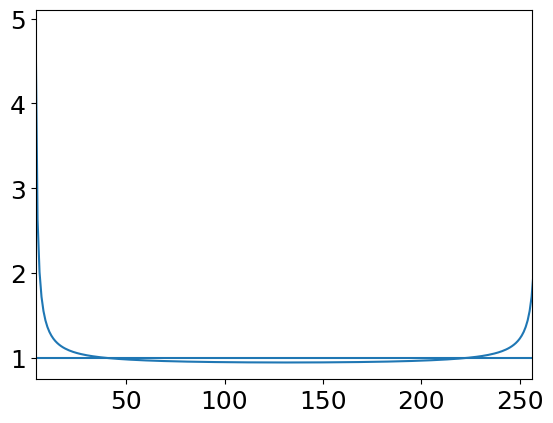

In [11]:
ginfo = ('cc',{'ntheta': lmax+9, 'nphi':2*(lmax+9)})
from pysht.geometry import get_geom
g = get_geom(ginfo)
gCC_CPU = g.weight
print(wGPU.shape, gCC_CPU.shape)
_ = np.zeros(shape=wGPU.shape)
_[4:-4] = wCPU
# plt.plot(wGPU)
# plt.plot(gCC_CPU)
# plt.plot(_)
plt.plot(gCC_CPU/_)
plt.hlines(1,4,256)
plt.xlim(4, 256)

In [ ]:
from lenspyx.tests.helper import syn_ffi_ducc_29, cls_unl
from lenspyx.utils import timer
from lenspyx.utils_hp import Alm, synalm
import numpy as np
import pylab as pl
import healpy as hp

tim = timer(True)
ffi, _ = syn_ffi_ducc_29(lmax_len=phi_lmax, dlmax=0, dlmax_gl=0, dlm=toydlm, epsilon=epsilon)
Aunl = ffi.dlm2A()

lmax, mmax = phi_lmax, phi_lmax
# tlm_unl = synalm(cls_unl['tt'][:lmax + 1], lmax, mmax).astype(np.complex64)
tmap_len = ffi.gclm2lenmap(toyunllm, mmax, 0, backwards=False)

points1 = tmap_len.copy()
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points1[ofs:ofs + nph] *= w
points1 = points1
points2 = tmap_len * Aunl
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points2[ofs:ofs + nph] *= w
points2 = points2

tlm_unl_1 = ffi.lenmap2gclm(points1, 0, lmax, mmax).astype(np.complex128)
tlm_unl_2 = ffi.lenmap2gclm(points2, 0, lmax, mmax).astype(np.complex128)
# tlm_unl_3 = ffi.lenmap2gclm(np.atleast_2d(Tsky2), 0, lmax, mmax).astype(np.complex128)

deflection std is 2.43e+00 amin
1024 1024 1024 1024
deflection: I set numthreads to 40
 DUCC 40 threads deflection instantiated 1e-14
inside _build_d1
lmax_dlm:  1023
mmax_dlm:  1023
----
shape d1:  (2, 1521160)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 1521160)
lmax_dlm:  1023
mmax_dlm:  1023
shapes:  (1024,) (1024,) (1024,) (1024,) (2, 1521160)
(1521160, 3)
  dlm2A                                :  [0:00:00.180402] (59.2%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.040890] (13.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.012139] (4.0%)  
  build_angles                         :  [0:00:00.053045] (17.4%)  
  synthesis general (STANDARD)         :  [0:00:00.070934] (23.3%)  
  gclm2lenmap                          :  [0:00:00.124077] (40.7%)  
  Total                                :  [0:00:00.304938] d:h:m:s:mus



Total wall clock time for synthesis_general: 0.0703s
|
+- getPlane                          : 54.55% (0.0384s)
|  |
|  +- alm2leg                           : 46.44% (0.0178s)
|  +- theta resampling and deconvolution: 27.16% (0.0104s)
|  +- phi FFT and dconvolution          : 24.75% (0.0095s)
|  +- dealing with borders              :  1.63% (0.0006s)
|  
+- interpol (u2nu)                   : 45.10% (0.0317s)
+- SphereInterpol setup              :  0.32% (0.0002s)
+- build_planes                      :  0.03% (0.0000s)
+- setup                             :  0.00% (0.0000s)

Total wall clock time for adjoint_synthesis_general: 0.07173s
|
+- deinterpol (nu2u)                 : 53.88% (0.0386s)
+- updateAlm                         : 41.77% (0.0300s)
|  |
|  +- leg2alm                           : 43.82% (0.0131s)
|  +- phi FFT and deconvolution         : 30.59% (0.0092s)
|  +- theta resampling and deconvolution: 24.65% (0.0074s)
|  +- dealing with borders              :  0.90% (0.0003s)
|

(1.0, 1000.0)

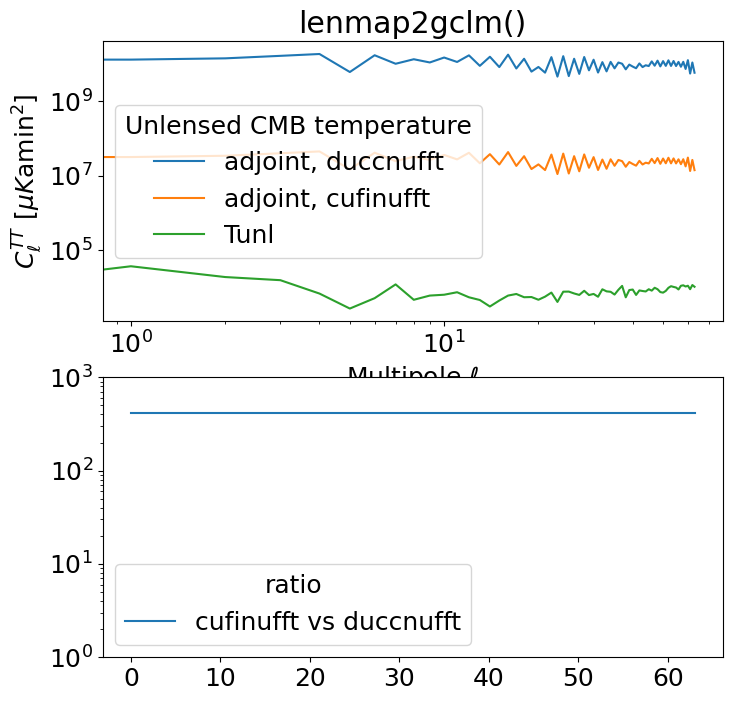

In [5]:
key = 'adjointsynthesis'
keyCPU = 'adjointsynthesisgeneral'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(2,1, figsize=(8,8))

ll = np.arange(1,phi_lmax+2)*np.arange(2, phi_lmax+3)
resCPU = defres['CPU'][solverCPU][keyCPU][0]
resGPU = defres['GPU'][solverGPU][key][0]


ax[0].plot(ll*hp.alm2cl(resCPU.astype(complex)), label="adjoint, " + solverCPU)
ax[0].plot(ll*hp.alm2cl(resGPU.astype(complex)), label="adjoint, " + solverGPU)
ax[0].plot(ll*hp.alm2cl(toyunllm), label='Tunl')

# ax[0].plot(ll*1e-10*hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(ll*1e-10*hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')

# ax[0].set_ylim(1e3, 1e5)
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

# ax[1].plot(hp.alm2cl(resCPU)/hp.alm2cl(toyunllm), label='lenspyx vs truth ')
# ax[1].plot(hp.alm2cl(resGPU)/hp.alm2cl(toyunllm), label='cufinufft vs truth')
ax[1].plot(hp.alm2cl(resCPU)/hp.alm2cl(resGPU), label='cufinufft vs duccnufft')
ax[1].legend(title='ratio')
ax[0].loglog()
ax[1].set_yscale('log')
ax[1].set_ylim(1e0,1e3)
# ax[1].set_ylim(1.012,1.06)
# ax[1].set_ylim(0.95,1.158)

# ax[1].set_xscale('log')
# ax[1].plot(hp.alm2cl(), label=solverGPU)

In [3]:
hp.alm2cl(resCPU)/hp.alm2cl(resGPU)

array([103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205,
       103.75289205, 103.75289205, 103.75289205, 103.75289205])

In [7]:
415.0115682/103.75289205

4.0

In [6]:
hp.alm2cl(resCPU)/hp.alm2cl(resGPU)

array([415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682, 415.0115682,
       415.0115682, 415.0115682, 415.0115682, 415.0115682])

## Compare with lenpyx test

In [ ]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'
vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0].shape)

# ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['CPU'][solverGPU][key][0][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen)')
ax[1].set_ylim(0.99,1.21)

ax[2].plot(Tsky2-tmap_len[0])
ax[2].set_xlim(0,10000)

# CPU vs GPU

## Only for lenpsyx

In [ ]:
keyGPU = 'nuFFT'
keyCPU = 'synthesisgeneral'
# Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = resCPU #defres['GPU'][keyGPU][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'

print(defres['CPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
defres['CPU'].keys()

# all others

### pointing things

(2, 2097152) (2, 2097152)


/tmp/ipykernel_2251848/1683915390.py:16: RuntimeWarning: invalid value encountered in divide
  ax[2,1].imshow((defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)


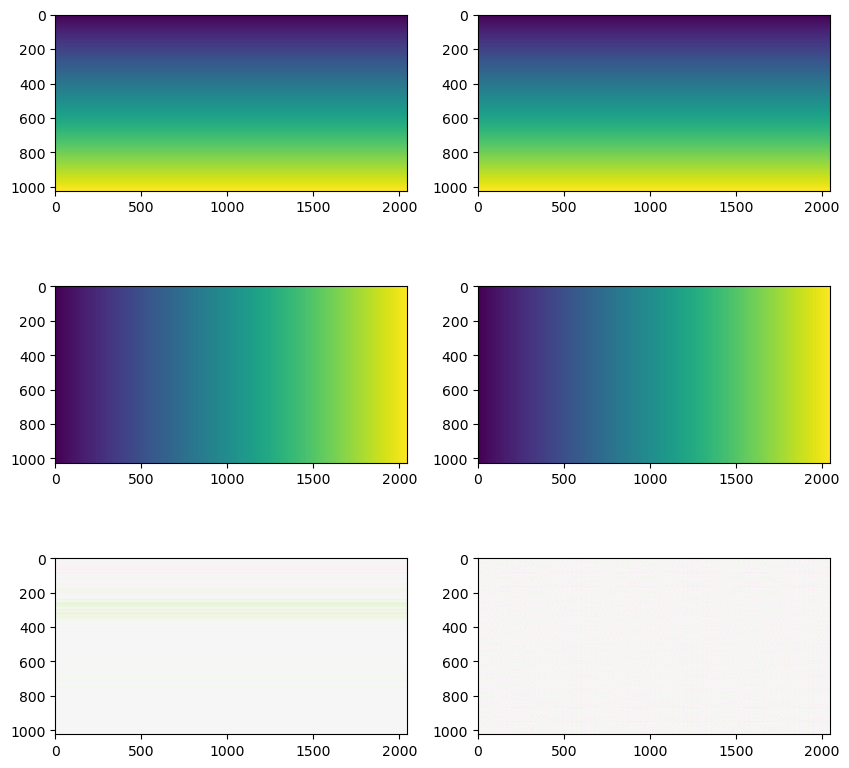

In [5]:
key = 'dlm2pointing'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))


vmin, vmax = -1e-15, 1e-15
ax[2,0].imshow((defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow((defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1)) / defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

## synthesis general

(1, 2062, 2048) (2062, 2048)


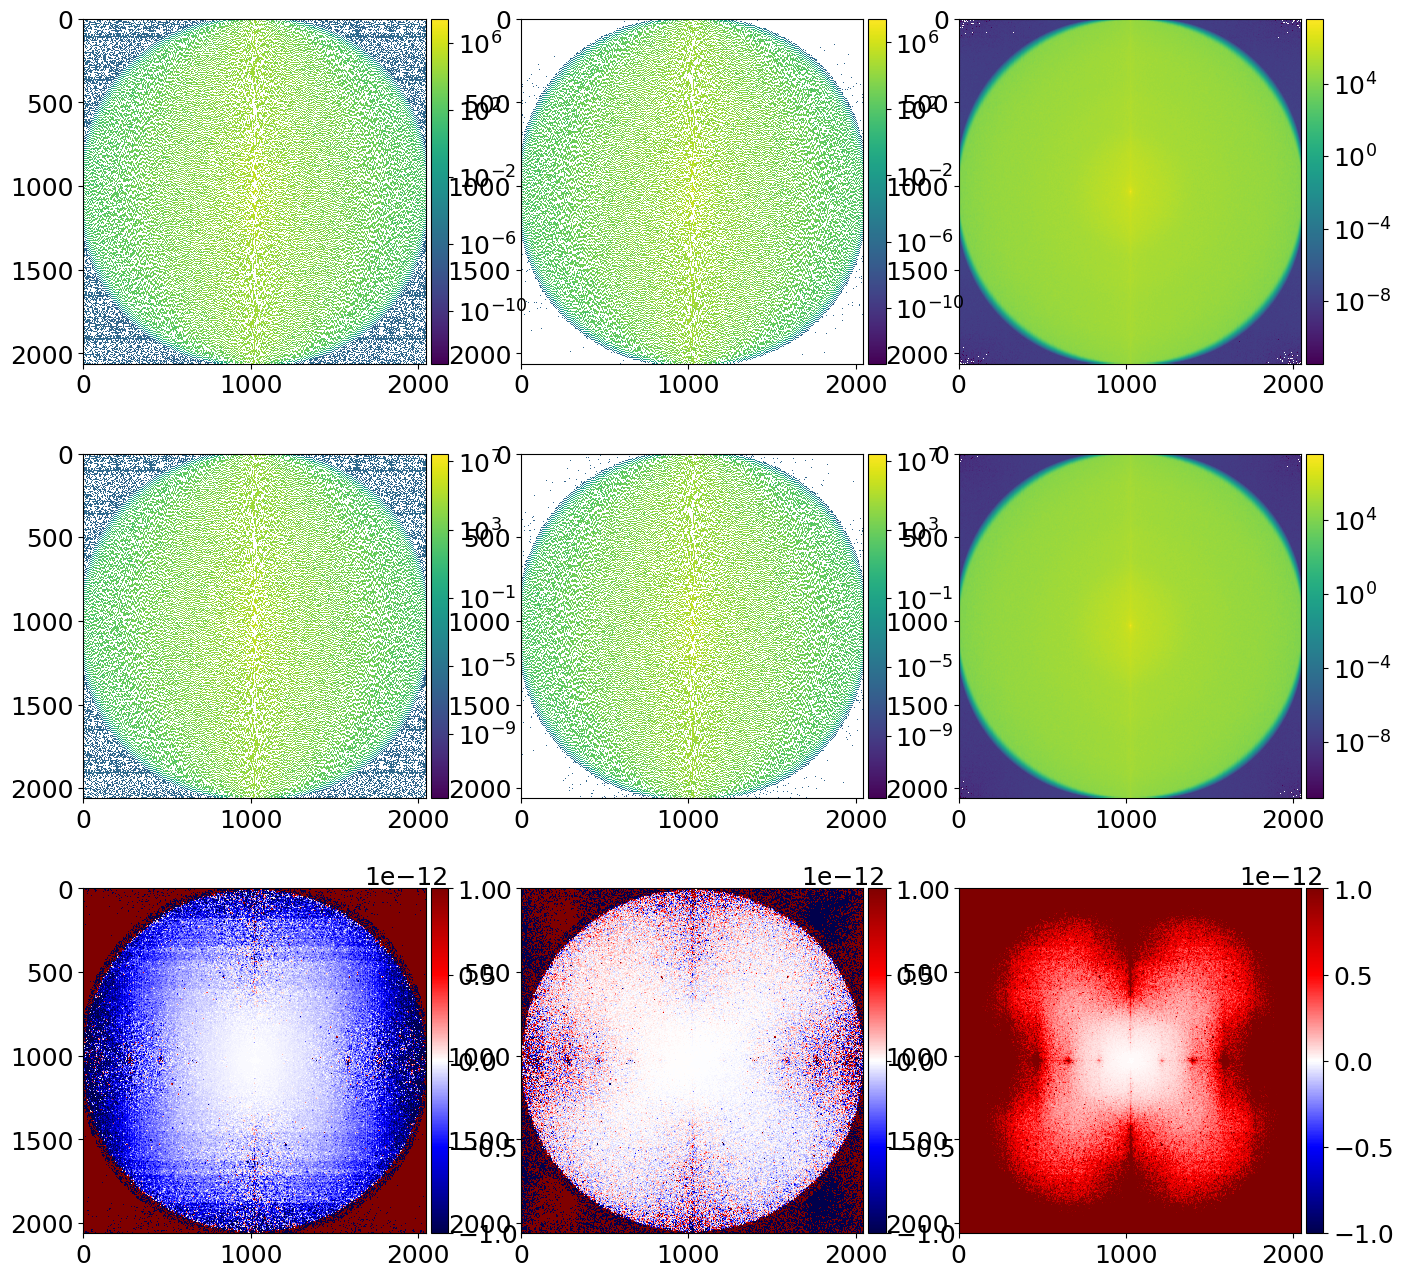

In [13]:
key = 'nuFFT2d1'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,3, figsize=(16,16))

resCPU = np.fft.fftshift(defres['CPU'][solverCPU][key].reshape(2*t.ntheta_CAR-2,-1),axes=(0,1))
resGPU = defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)

im = ax[0,0].imshow(np.real(resCPU), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(resCPU), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(resCPU), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(resGPU), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(resGPU), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(resGPU), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-12, 1e-12
# vmin, vmax = None, None
im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(2062, 2048) (2062, 2048)


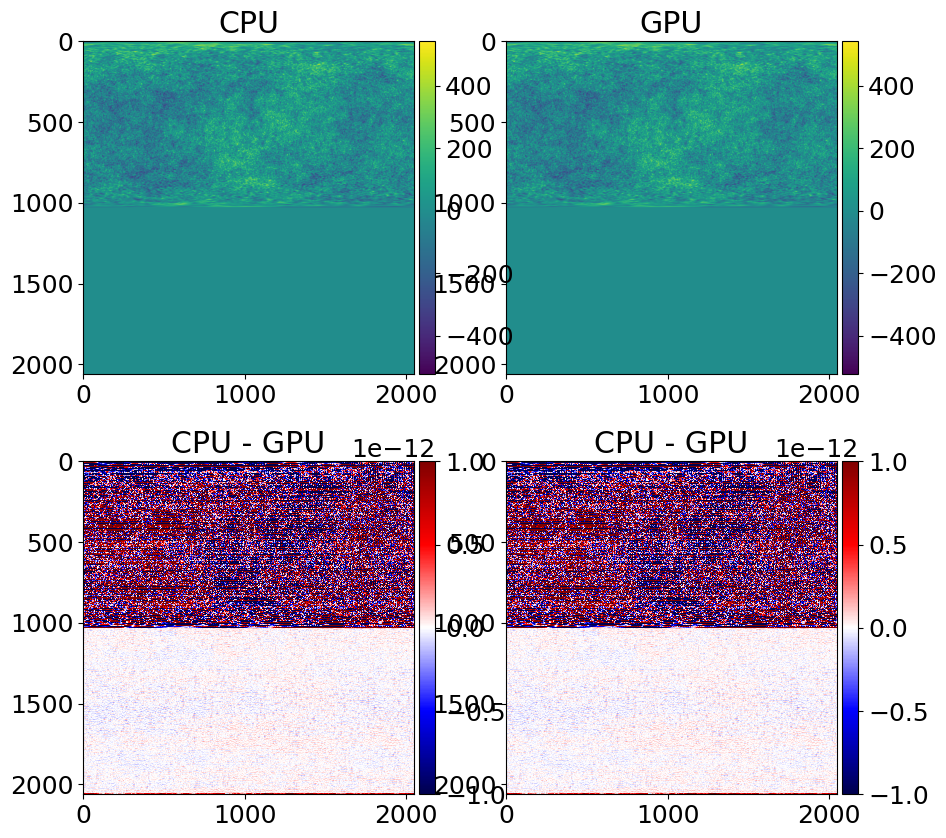

In [14]:
key = 'iC2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'

vmin, vmax = -4e2, 4e2
vmin, vmax = None, None
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
Tsky = Tsky2

resCPU = np.real(defres['CPU'][solverCPU][key])#[::2,::2])
resGPU = np.real(defres['GPU'][solverGPU][key])#[::2,::2])
n=1

fig, ax = plt.subplots(2,2, figsize=(10,10))

# ax[0,0].imshow(Tsky[:500*(t.nphi_CAR)].reshape(-1,t.nphi_CAR).real, vmin=vmin, vmax=vmax)
# ax[0,0].imshow(Tsky.reshape(2*t.ntheta_CAR-2,t.nphi_CAR), vmin=vmin, vmax=vmax)
# ax[0,0].set_title('Tsky')

im = ax[0,0].imshow(resCPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n), vmin=vmin, vmax=vmax)
ax[0,0].set_title('CPU')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(resGPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n).astype(np.double), vmin=vmin, vmax=vmax)
ax[0,1].set_title('GPU')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-12, 1e-12
im = ax[1,0].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,1].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(-1.0, 1.0)

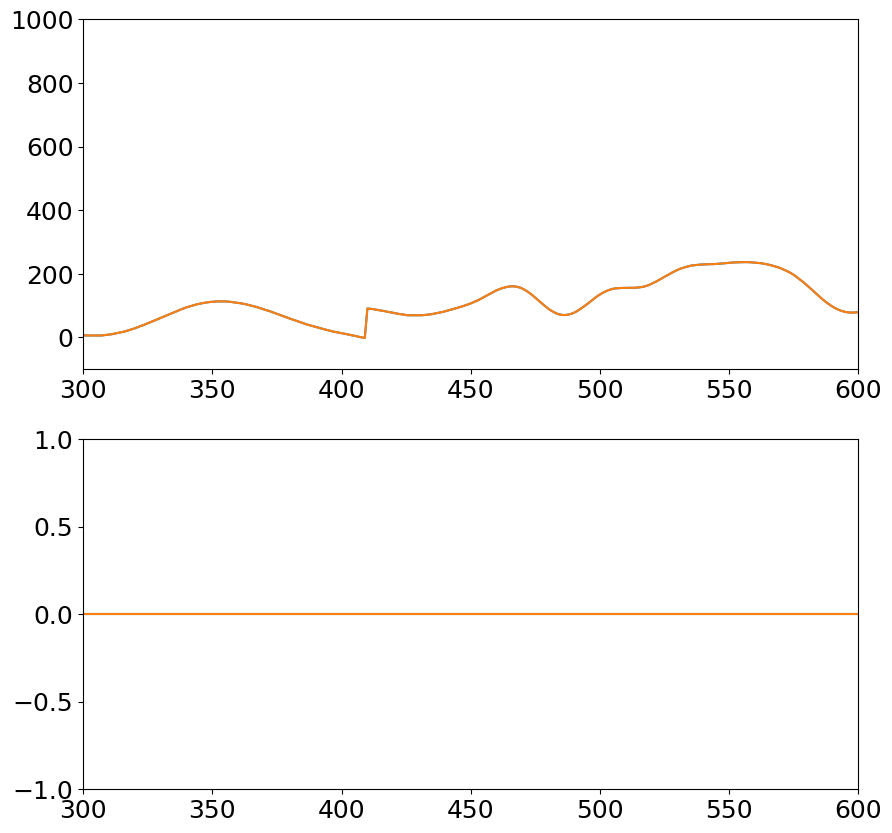

In [15]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(resCPU.real.flatten()[::10])
ax[0].plot(resGPU.real.flatten()[::10])
ax[0].set_xlim(0,2e6)
ax[0].set_xlim(300,600)
ax[0].set_ylim(-1e2,1e3)

ax[1].plot(resCPU.imag.flatten()[::1000])
ax[1].plot(resGPU.imag.flatten()[::1000])
ax[1].set_xlim(0,2e6)
ax[1].set_xlim(300,600)
ax[1].set_ylim(-1e0,1e0)
# plt.imshow(defres['GPU'][solverGPU][key][0][::2,::2].real)

(1032, 2048) (1032, 2048)


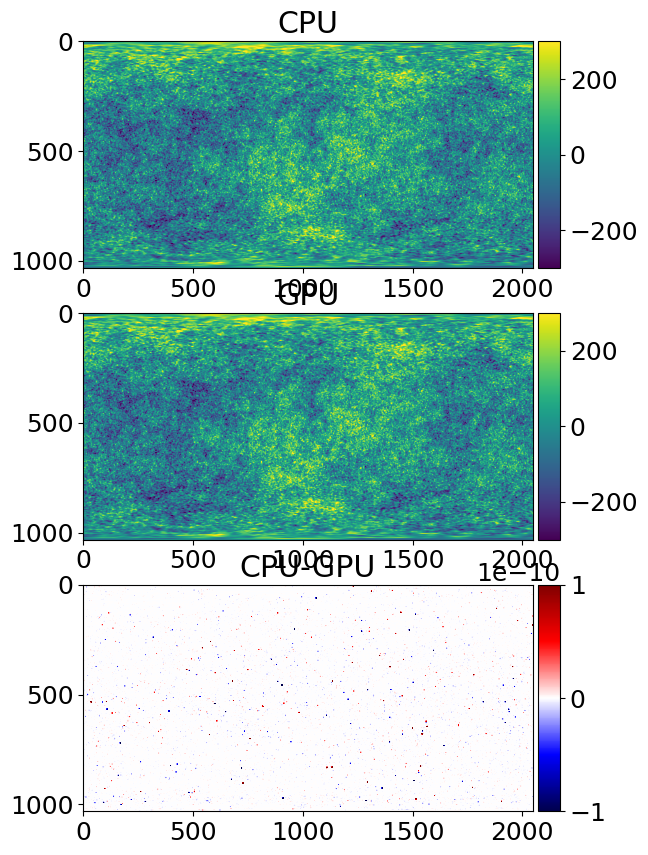

In [2]:
key = 'adjointdoubling'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(3,1, figsize=(8,10))

resCPU = defres['CPU'][solverCPU][key][0].real
resGPU = defres['GPU'][solverGPU][key].reshape(-1,t.constructor.nphi)
print(resCPU.shape, resGPU.shape)

vmin, vmax = -3e2, 3e2
im = ax[0].imshow(resCPU, vmin=vmin, vmax=vmax)
ax[0].set_title('CPU')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(resGPU, vmin=vmin, vmax=vmax)
ax[1].set_title('GPU')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax = -1e-10, 1e-10
im = ax[2].imshow((resCPU-resGPU)/resCPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1, 524800) (1, 524800)


/tmp/ipykernel_748097/2997664340.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(resCPU/hp.alm2cl(toyunllm), label=solverCPU)
/tmp/ipykernel_748097/2997664340.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(resGPU/hp.alm2cl(toyunllm), label=solverGPU)


(0.95, 1.01)

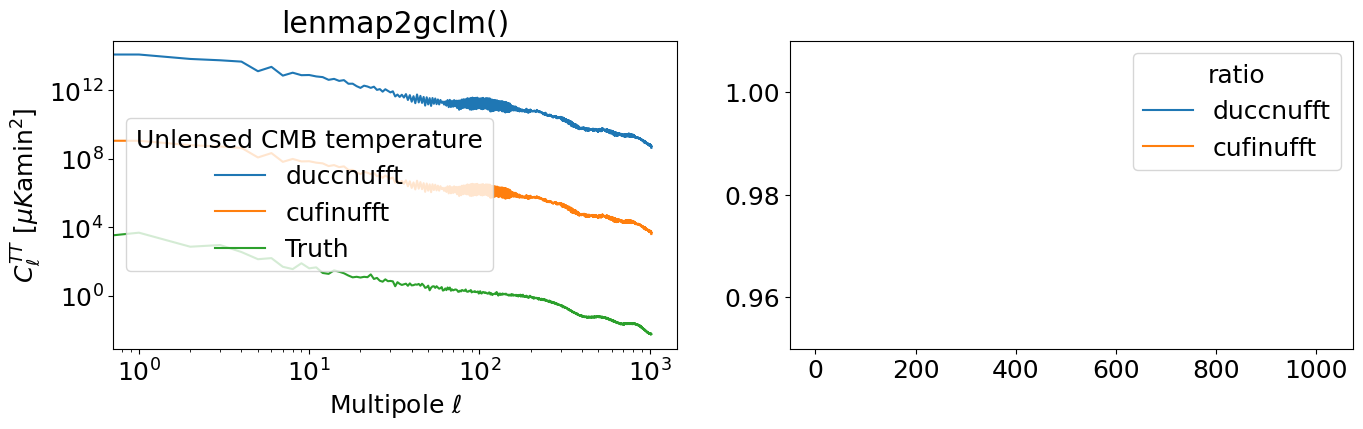

In [5]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
vmin = -1e-10
vmax = 1e-10
fig, ax = plt.subplots(1,2, figsize=(16,4))
print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)

resCPU = hp.alm2cl(defres['CPU'][solverCPU][key][0])
resGPU = hp.alm2cl(defres['GPU'][solverGPU][key][0])

ax[0].plot(resCPU, label=solverCPU)
ax[0].plot(resGPU, label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(resCPU/hp.alm2cl(toyunllm), label=solverCPU)
ax[1].plot(resGPU/hp.alm2cl(toyunllm), label=solverGPU)
ax[1].plot(0,0)
# ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')
ax[1].legend(title='ratio')
ax[1].set_ylim(0.95,1.01)
# ax[1].loglog()
# ax[1].plot(hp.alm2cl(), label=solverGPU)